In [35]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split , learning_curve
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
#from xgboost import XGBClassifier 


 # Data Ingestion 

In [37]:
df = pd.read_csv('data.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


# Data Preprocessing 

<Axes: xlabel='Region_Code', ylabel='Response'>

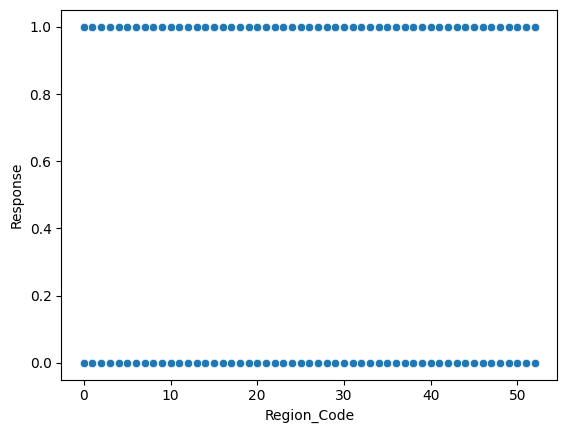

In [39]:
sns.scatterplot(x='Region_Code',y='Response',data=df)

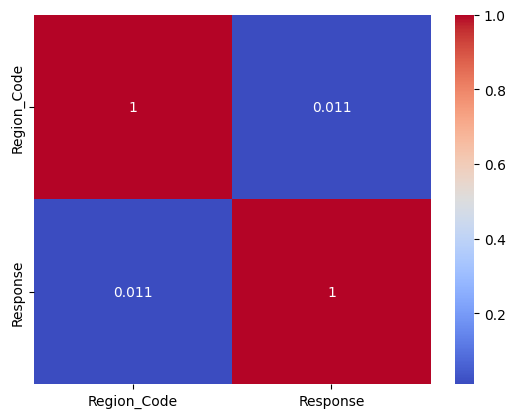

In [ ]:
sns.heatmap(df[['Region_Code','Response']].corr(), annot=True, cmap='coolwarm')  
plt.show()

In [40]:
df.drop(['id','Region_Code'],axis=1,inplace=True)

In [41]:
df.head(2)

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,0,1-2 Year,No,33536.0,26.0,183,0


In [42]:
df['Vehicle_Age'].value_counts()

Vehicle_Age
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: count, dtype: int64

In [21]:
df['Response'].value_counts()

Response
0    334399
1     46710
Name: count, dtype: int64

In [22]:
df['Driving_License'].value_counts()

Driving_License
1    380297
0       812
Name: count, dtype: int64

<Axes: xlabel='Annual_Premium', ylabel='Policy_Sales_Channel'>

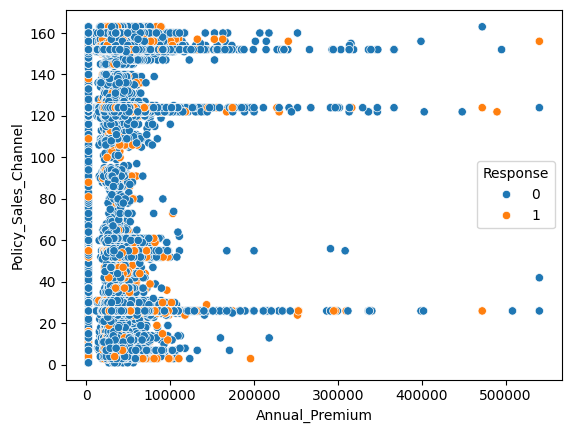

In [55]:
sns.scatterplot(x='Annual_Premium',y='Policy_Sales_Channel',hue='Response',data=df)

In [43]:
X = df.drop('Response',axis=1) 
y = df['Response']

<Axes: >

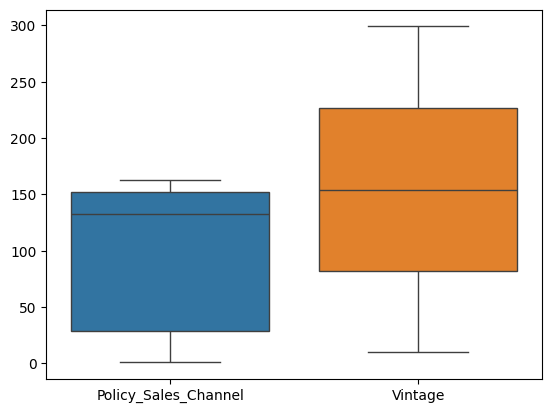

In [44]:
sns.boxplot(X[['Policy_Sales_Channel',	'Vintage']])

<Axes: >

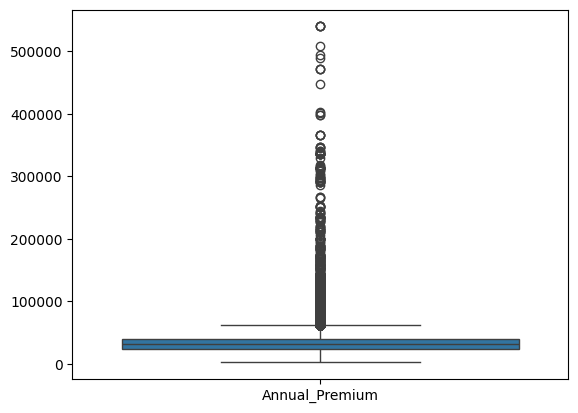

In [45]:
sns.boxplot(X[['Annual_Premium']])

In [46]:
df.columns

Index(['Gender', 'Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Age',
       'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage',
       'Response'],
      dtype='object')

In [53]:
algorithms = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42,n_estimators=200),
  #  'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'KNN': KNeighborsClassifier()
}

In [54]:
# Define features
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
numeric_features = ['Age', 'Vintage']
numeric_features_with_outlier = ['Annual_Premium']
passthrough_features = ['Driving_License', 'Previously_Insured', 'Policy_Sales_Channel']

# Define transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore',drop='first')
numeric_transformer = StandardScaler()
numeric_transformer_outlier = RobustScaler()

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features),
        ('num_outlier', numeric_transformer_outlier, numeric_features_with_outlier),
        ('passthrough', 'passthrough', passthrough_features)
    ])

In [55]:
def plot_data(mean_scores, std_dev, sizes, ax, label):
    ax.plot(sizes, mean_scores, marker='o' , label=f'{label} Mean')
    ax.fill_between(x=sizes,
                    y1=mean_scores - std_dev,
                    y2 = mean_scores + std_dev,
                    alpha=0.5, label=f'{label} Variation'
                    )

In [56]:
def plot_learning_curve(name, algo):
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', algo)
    ])

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=3, scoring='accuracy', n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    train_score = f"{train_scores_mean[-1]:.2f} +/- {train_scores_std[-1]:.2f}"


    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    test_score = f"{test_scores_mean[-1]:.2f} +/- {test_scores_std[-1]:.2f}"

    fig,ax = plt.subplots()

    # Plot training set
    plot_data(train_scores_mean, train_scores_std, train_sizes, ax, label= f"Training ({train_score})")
    # Plot testing set
    plot_data(test_scores_mean, test_scores_std, train_sizes, ax, label=f"Testing ({test_score})")

    ax.set_xlabel('Training Sizes')
    ax.set_title(f"Learning Curve for {name}")
    ax.set_ylabel('Accuracy')
    ax.grid(True)
    ax.legend()
    plt.show()


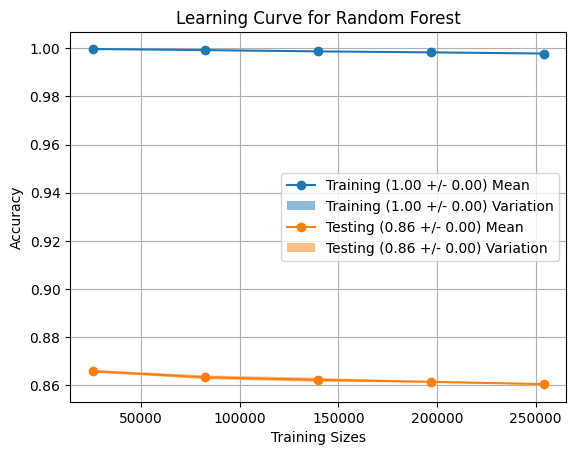

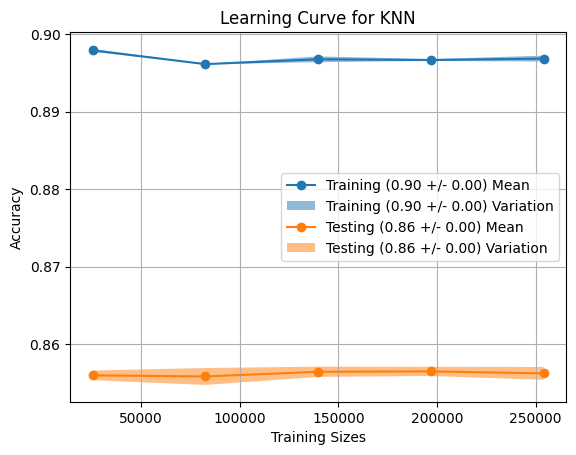

In [57]:

for name, algo in algorithms.items():
    plot_learning_curve(name, algo)